In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import sys
import shutil

sys.path.append('/jet/home/tvnguyen/accreted_catalog/gaia_accreted_catalog')

import ml_collections
import numpy as np
import scipy.special as special
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from ml_collections import config_flags
from memory_profiler import profile

import datasets
from models import models, classifier, utils, infer_utils

%matplotlib inline
plt.style.use('/jet/home/tvnguyen/mplstyle/default.mplstyle')

In [2]:
# read in the model
logdir = '/ocean/projects/phy210068p/tvnguyen/accreted_catalog/logging'
model_names = (
    'blue-mark-91',
    'dizzy-spiral-82'
)
results = []
for i in range(len(model_names)):
    name = model_names[i]
    results_path = os.path.join(logdir, name, 'results.val.pkl')
    with open(results_path, 'rb') as f:
        results.append(pickle.load(f))

In [3]:
# get ROC curve
def roc_curve(y_true, y_score, thresholds):
    tpr = []
    fpr = []
    for threshold in thresholds:
        y_pred = (y_score > threshold)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return np.array(fpr), np.array(tpr)

def eff(y_true, y_score, thresholds):
    """ Get the efficiency and purity for a given threshold """
    epsilon_0 = []  # efficiency for class 0
    epsilon_1 = []  # efficiency for class 1
    purity = []  # purity for class 1
    for threshold in thresholds:
        y_pred = (y_score > threshold)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        epsilon_0.append(fp / (tn + fp))
        epsilon_1.append(tp / (tp + fn))
        purity.append(tp / (tp + fp))
    return np.array(epsilon_0), np.array(epsilon_1), np.array(purity)

/tmp/ipykernel_83080/596842009.py:29: RuntimeWarning: invalid value encountered in scalar divide
  purity.append(tp / (tp + fp))


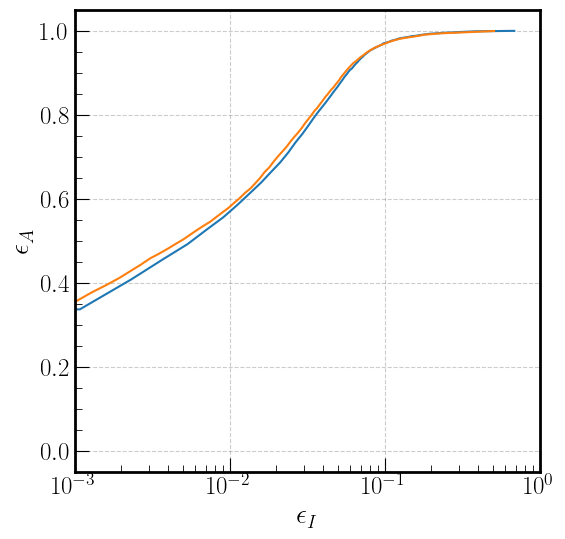

In [4]:
fig, ax = plt.subplots()

labels = ('4D', '5D', '6D')

for i in range(len(model_names)):
    result = results[i]
    y_true = result['y_true']
    y_pred_score = result['y_pred_score']

    thresholds = np.linspace(0.001, 1, 100)
    eps_i, eps_a, purity = eff(y_true, y_pred_score, thresholds)

    ax.plot(eps_i, eps_a, label=labels[i])
ax.set_xlabel(r'$\epsilon_{I}$')
ax.set_ylabel(r'$\epsilon_{A}$')
ax.set_xscale('log')
ax.set_xlim(1e-3, 1)

plt.show()